In [143]:
# This constitutes the game logic

# %%
from random import randint, uniform
from numpy import *

# %%
def add_two(mat):
    a = randint(0, len(mat)-1) # Choose any x
    b = randint(0, len(mat)-1) # Choose any y

    while(mat[a][b]!=0):  # If the x,y coord is occupied, try again and again
        a = randint(0,len(mat)-1)
        b = randint(0,len(mat)-1)

    # 10% chance that the number will be 4 instead of 2. 
    mat[a][b] = (uniform(0, 1) < 0.1)*2 + 2  

    return mat

def reverse(mat):
    new=[]
    for i in range(len(mat)):
        new.append([])
        for j in range(len(mat[0])):
            new[i].append(mat[i][len(mat[0])-j-1])
    return new

def transpose(mat):
    new=[]
    for i in range(len(mat[0])):
        new.append([])
        for j in range(len(mat)):
            new[i].append(mat[j][i])
    return new

def cover_up(mat):
    new = [[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]]
    done = False
    for i in range(4):
        count=0
        for j in range(4):
            if mat[i][j]!=0:
                new[i][count]=mat[i][j]
                if j!=count:
                    done=True
                count+=1
    return new, done

def merge(mat):
    done = False
    addPoints = 0
    for i in range(4):
         for j in range(3):
             if mat[i][j]==mat[i][j+1] and mat[i][j]!=0:
                 mat[i][j]*=2
                 addPoints += mat[i][j]
                 mat[i][j+1]=0
                 done=True
    return mat, done, addPoints

# This also constitutes the game logic

class GameState:
    """ Simple version of the 2048 board with moves, processing, and point system available.
        Use this class to pair with MCTS algorithm. """

    def __init__(self, mat):
        self.matrix = mat
        self.point_count = 0

    def __str__(self):
        s = ""
        for i in range(4):
            for j in range(4):
                s += "\t"
                s += str(self.matrix[i][j])
                if j == 3:
                    s += "\n"
        return s

    def game_state(self):
        mat = self.matrix
        for i in range(len(mat)):
            for j in range(len(mat[0])):
                if mat[i][j]==2048:
                    return 'win'
        for i in range(len(mat)-1): # Intentionally reduced to check the row on the right and below
            for j in range(len(mat[0])-1): # More elegant to use exceptions but most likely this will be their solution
                if mat[i][j]==mat[i+1][j] or mat[i][j+1]==mat[i][j]:
                    return 'not over'
        for i in range(len(mat)): # Check for any zero entries
            for j in range(len(mat[0])):
                if mat[i][j]==0:
                    return 'not over'
        for k in range(len(mat)-1): # To check the left/right entries on the last row
            if mat[len(mat)-1][k]==mat[len(mat)-1][k+1]:
                return 'not over'
        for j in range(len(mat)-1): # Check up/down entries on last column
            if mat[j][len(mat)-1]==mat[j+1][len(mat)-1]:
                return 'not over'
        return 'lose'

    # Done indicates whether the move does anything
    def up(self):
        game = self.matrix
        game = transpose(game)
        game, done = cover_up(game)
        temp = merge(game)
        game = temp[0]
        done = done or temp[1]
        game = cover_up(game)[0]
        game = transpose(game)
        add_points = temp[2]
        return game, done, add_points

    def down(self):
        game = self.matrix
        game = reverse(transpose(game))
        game, done = cover_up(game)
        temp = merge(game)
        game = temp[0]
        done = done or temp[1]
        game = cover_up(game)[0]
        game = transpose(reverse(game))
        add_points = temp[2]
        return game, done, add_points

    def left(self):
        game = self.matrix
        game, done = cover_up(game)
        temp = merge(game)
        game = temp[0]
        done = done or temp[1]
        game = cover_up(game)[0]
        add_points = temp[2]
        return game, done, add_points

    def right(self):
        game = self.matrix
        game = reverse(game)
        game, done = cover_up(game)
        temp = merge(game)
        game = temp[0]
        done = done or temp[1]
        game = cover_up(game)[0]
        game = reverse(game)
        add_points = temp[2]
        return game, done, add_points

    def clone(self):
        st = GameState(self.matrix)
        st.point_count = self.point_count
        return st
    
    def do_move(self, move):
        """ Move input should be one of the following: "up", "down", "left", "right"
            Make sure when this function is called, the move is a possible move. """
        move_funcs = {
            'up':       self.up(),
            'down':     self.down(),
            'left':     self.left(),
            'right':    self.right()
        }

        self.matrix, _, add_points = move_funcs[move]
        self.point_count += add_points # Update Points
        
        # Check if there any zeros in the grid.
        zero_exists = False
        for i in range(4):
            for j in range(4):
                if self.matrix[i][j] == 0:
                    zero_exists = True
                    break
        
        if zero_exists:
            self.matrix = add_two(self.matrix) # Add 2 or 4 in the matrix
            game_over = self.game_state() != 'not over'
            return game_over 
        else:
            game_over = True
            return game_over 
        
    def get_moves(self):
        """ Get all possible moves from this state. """
        _, done_up, _     = self.up()
        _, done_down, _   = self.down()
        _, done_left, _   = self.left()
        _, done_right, _  = self.right()

        move_possible = []
        if done_up:
            move_possible.append("up")
        if done_down:
            move_possible.append("down")
        if done_left:
            move_possible.append("left")
        if done_right:
            move_possible.append("right")
        
        return move_possible

    def get_result(self):
        """ Get the score of the given state."""
        return self.point_count

# %%
if __name__ == "__main__":
    initialMat = [[4,2,4,0],[0,0,4,0],[0,2,0,0],[8,0,2,0]]
    deathMatrix = [[8, 4, 2, 8], [2, 16, 8, 4], [256, 32, 4, 2], [4, 2, 4, 2]]

# --------------
# 2048 RL TRAINING FIXED
# --------------

import numpy as np
import random
import pickle

# -----------------
# GameState class
# -----------------

class GameState:
    def __init__(self, mat=None):
        self.matrix = np.array(mat) if mat is not None else np.zeros((4, 4), dtype=int)

    def clone(self):
        return GameState(self.matrix.copy())

    def add_random_tile(self):
        empty = list(zip(*np.where(self.matrix == 0)))
        if empty:
            y, x = random.choice(empty)
            self.matrix[y][x] = 2 if random.random() < 0.9 else 4

    def get_moves(self):
        moves = []
        for move in ['up', 'down', 'left', 'right']:
            clone = self.clone()
            if clone.do_move(move):
                moves.append(move)
        return moves

    def do_move(self, direction):
        moved = False
        for i in range(4):
            if direction in ('left', 'right'):
                line = self.matrix[i, :]
            else:
                line = self.matrix[:, i]

            if direction in ('right', 'down'):
                line = line[::-1]

            merged_line, done = self.merge(line)

            if done:
                moved = True
                if direction in ('left', 'right'):
                    if direction == 'left':
                        self.matrix[i, :] = merged_line
                    else:
                        self.matrix[i, :] = merged_line[::-1]
                else:
                    if direction == 'up':
                        self.matrix[:, i] = merged_line
                    else:
                        self.matrix[:, i] = merged_line[::-1]

        if moved:
            self.add_random_tile()
        return moved

    def merge(self, line):
        non_zero = line[line != 0]
        merged = []
        skip = False
        for j in range(len(non_zero)):
            if skip:
                skip = False
                continue
            if j + 1 < len(non_zero) and non_zero[j] == non_zero[j+1]:
                merged.append(non_zero[j]*2)
                skip = True
            else:
                merged.append(non_zero[j])
        merged = np.array(merged + [0]*(4-len(merged)))
        return merged, not np.array_equal(merged, line)

def available_moves(state):
    moves = []
    for action in [0, 1, 2, 3]:  # 0: up, 1: down, 2: left, 3: right
        temp_state = GameState(state.matrix.copy())  # Create a temporary game state
        _, moved = move(temp_state, action)  # <--- USE move() function
        if moved:
            moves.append(action)
    return moves


# -----------------
# N-Tuple TD Agent
# -----------------

class N_TupleTDAgent:
    def __init__(self, n_tuples, lr=0.005, gamma=9.99, lambd=0.5):
        self.n_tuples = n_tuples
        self.lr = lr
        self.gamma = gamma
        self.lambd = lambd
        self.weights = [{} for _ in range(len(n_tuples))]
        self.eligibilities = [{} for _ in range(len(n_tuples))]

    def flatten_board(self, board):
        return board.flatten()

    def get_tuple_value(self, board, tuple_indices, weight_table):
        key = tuple(board[i] for i in tuple_indices)
        return weight_table.get(key, 0.0)

    def estimate_value(self, board):
        flat = self.flatten_board(board)
        value = 0.0
        for tuple_indices, weight_table in zip(self.n_tuples, self.weights):
            value += self.get_tuple_value(flat, tuple_indices, weight_table)
        return value

    def accumulate_eligibilities(self, board):
        flat = self.flatten_board(board)
        for tuple_indices, eligibility_table in zip(self.n_tuples, self.eligibilities):
            key = tuple(flat[i] for i in tuple_indices)
            eligibility_table[key] = eligibility_table.get(key, 0.0) + 1.0

    def update(self, delta):
        for weight_table, eligibility_table in zip(self.weights, self.eligibilities):
            for key, eligibility in eligibility_table.items():
                weight_table[key] = weight_table.get(key, 0.0) + self.lr * delta * eligibility

    def decay_eligibilities(self):
        for eligibility_table in self.eligibilities:
            for key in eligibility_table:
                eligibility_table[key] *= self.gamma * self.lambd

    def reset_eligibilities(self):
        self.eligibilities = [{} for _ in range(len(self.n_tuples))]

    def choose_move(self, state):
        moves = state.get_moves()
        if not moves:
            return None
        best_move = None
        best_value = -float('inf')
        for move in moves:
            next_state = state.clone()
            next_state.do_move(move)
            value = self.estimate_value(next_state.matrix)
            if value > best_value:
                best_value = value
                best_move = move
        return best_move

    def train(self, state, move, reward, next_state, done):
        prediction = self.estimate_value(state.matrix)
        target = reward if done else reward + self.gamma * self.estimate_value(next_state.matrix)
        delta = target - prediction

        self.accumulate_eligibilities(state.matrix)
        self.update(delta)
        self.decay_eligibilities()

def new_game():
    state = GameState()
    state.add_random_tile()
    state.add_random_tile()
    return state.matrix

In [144]:
import pickle

# Load your trained agent
with open('agent_checkpoint1.pkl', 'rb') as f:
    agent = pickle.load(f)

# List all attributes and methods of the agent
print(dir(agent))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'accumulate_eligibilities', 'alpha', 'choose_move', 'decay_eligibilities', 'eligibility_traces', 'epsilon', 'estimate_value', 'flatten_board', 'gamma', 'get_tuple_value', 'lambda_', 'n_tuples', 'reset_eligibilities', 'train', 'update', 'value_table']


In [145]:
#!/usr/bin/env python
# coding: utf-8

# In[74]:


# This constitutes the game logic

# %%
from random import randint, uniform
from numpy import *

# %%
def add_two(mat):
    a = randint(0, len(mat)-1) # Choose any x
    b = randint(0, len(mat)-1) # Choose any y

    while(mat[a][b]!=0):  # If the x,y coord is occupied, try again and again
        a = randint(0,len(mat)-1)
        b = randint(0,len(mat)-1)

    # 10% chance that the number will be 4 instead of 2. 
    mat[a][b] = (uniform(0, 1) < 0.1)*2 + 2  

    return mat

def reverse(mat):
    new=[]
    for i in range(len(mat)):
        new.append([])
        for j in range(len(mat[0])):
            new[i].append(mat[i][len(mat[0])-j-1])
    return new

def transpose(mat):
    new=[]
    for i in range(len(mat[0])):
        new.append([])
        for j in range(len(mat)):
            new[i].append(mat[j][i])
    return new

def cover_up(mat):
    new = [[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]]
    done = False
    for i in range(4):
        count=0
        for j in range(4):
            if mat[i][j]!=0:
                new[i][count]=mat[i][j]
                if j!=count:
                    done=True
                count+=1
    return new, done

def merge(mat):
    done = False
    addPoints = 0
    for i in range(4):
         for j in range(3):
             if mat[i][j]==mat[i][j+1] and mat[i][j]!=0:
                 mat[i][j]*=2
                 addPoints += mat[i][j]
                 mat[i][j+1]=0
                 done=True
    return mat, done, addPoints


# In[75]:


# This also constitutes the game logic

class GameState:
    """ Simple version of the 2048 board with moves, processing, and point system available.
        Use this class to pair with MCTS algorithm. """

    def __init__(self, mat):
        self.matrix = mat
        self.point_count = 0

    def __str__(self):
        s = ""
        for i in range(4):
            for j in range(4):
                s += "\t"
                s += str(self.matrix[i][j])
                if j == 3:
                    s += "\n"
        return s

    def game_state(self):
        mat = self.matrix
        for i in range(len(mat)):
            for j in range(len(mat[0])):
                if mat[i][j]==2048:
                    return 'win'
        for i in range(len(mat)-1): # Intentionally reduced to check the row on the right and below
            for j in range(len(mat[0])-1): # More elegant to use exceptions but most likely this will be their solution
                if mat[i][j]==mat[i+1][j] or mat[i][j+1]==mat[i][j]:
                    return 'not over'
        for i in range(len(mat)): # Check for any zero entries
            for j in range(len(mat[0])):
                if mat[i][j]==0:
                    return 'not over'
        for k in range(len(mat)-1): # To check the left/right entries on the last row
            if mat[len(mat)-1][k]==mat[len(mat)-1][k+1]:
                return 'not over'
        for j in range(len(mat)-1): # Check up/down entries on last column
            if mat[j][len(mat)-1]==mat[j+1][len(mat)-1]:
                return 'not over'
        return 'lose'

    # Done indicates whether the move does anything
    def up(self):
        game = self.matrix
        game = transpose(game)
        game, done = cover_up(game)
        temp = merge(game)
        game = temp[0]
        done = done or temp[1]
        game = cover_up(game)[0]
        game = transpose(game)
        add_points = temp[2]
        return game, done, add_points

    def down(self):
        game = self.matrix
        game = reverse(transpose(game))
        game, done = cover_up(game)
        temp = merge(game)
        game = temp[0]
        done = done or temp[1]
        game = cover_up(game)[0]
        game = transpose(reverse(game))
        add_points = temp[2]
        return game, done, add_points

    def left(self):
        game = self.matrix
        game, done = cover_up(game)
        temp = merge(game)
        game = temp[0]
        done = done or temp[1]
        game = cover_up(game)[0]
        add_points = temp[2]
        return game, done, add_points

    def right(self):
        game = self.matrix
        game = reverse(game)
        game, done = cover_up(game)
        temp = merge(game)
        game = temp[0]
        done = done or temp[1]
        game = cover_up(game)[0]
        game = reverse(game)
        add_points = temp[2]
        return game, done, add_points

    def clone(self):
        st = GameState(self.matrix)
        st.point_count = self.point_count
        return st
    
    def do_move(self, move):
        """ Move input should be one of the following: "up", "down", "left", "right"
            Make sure when this function is called, the move is a possible move. """
        move_funcs = {
            'up':       self.up(),
            'down':     self.down(),
            'left':     self.left(),
            'right':    self.right()
        }

        self.matrix, _, add_points = move_funcs[move]
        self.point_count += add_points # Update Points
        
        # Check if there any zeros in the grid.
        zero_exists = False
        for i in range(4):
            for j in range(4):
                if self.matrix[i][j] == 0:
                    zero_exists = True
                    break
        
        if zero_exists:
            self.matrix = add_two(self.matrix) # Add 2 or 4 in the matrix
            game_over = self.game_state() != 'not over'
            return game_over 
        else:
            game_over = True
            return game_over 
        
    def get_moves(self):
        """ Get all possible moves from this state. """
        _, done_up, _     = self.up()
        _, done_down, _   = self.down()
        _, done_left, _   = self.left()
        _, done_right, _  = self.right()

        move_possible = []
        if done_up:
            move_possible.append("up")
        if done_down:
            move_possible.append("down")
        if done_left:
            move_possible.append("left")
        if done_right:
            move_possible.append("right")
        
        return move_possible

    def get_result(self):
        """ Get the score of the given state."""
        return self.point_count

# %%
if __name__ == "__main__":
    initialMat = [[4,2,4,0],[0,0,4,0],[0,2,0,0],[8,0,2,0]]
    deathMatrix = [[8, 4, 2, 8], [2, 16, 8, 4], [256, 32, 4, 2], [4, 2, 4, 2]]


# In[ ]:


# --------------
# 2048 RL TRAINING FIXED
# --------------

import numpy as np
import random
import pickle

# -----------------
# GameState class
# -----------------

class GameState:
    def __init__(self, mat=None):
        self.matrix = np.array(mat) if mat is not None else np.zeros((4, 4), dtype=int)

    def clone(self):
        return GameState(self.matrix.copy())

    def add_random_tile(self):
        empty = list(zip(*np.where(self.matrix == 0)))
        if empty:
            y, x = random.choice(empty)
            self.matrix[y][x] = 2 if random.random() < 0.9 else 4

    def get_moves(self):
        moves = []
        for move in ['up', 'down', 'left', 'right']:
            clone = self.clone()
            if clone.do_move(move):
                moves.append(move)
        return moves

    def do_move(self, direction):
        moved = False
        for i in range(4):
            if direction in ('left', 'right'):
                line = self.matrix[i, :]
            else:
                line = self.matrix[:, i]

            if direction in ('right', 'down'):
                line = line[::-1]

            merged_line, done = self.merge(line)

            if done:
                moved = True
                if direction in ('left', 'right'):
                    if direction == 'left':
                        self.matrix[i, :] = merged_line
                    else:
                        self.matrix[i, :] = merged_line[::-1]
                else:
                    if direction == 'up':
                        self.matrix[:, i] = merged_line
                    else:
                        self.matrix[:, i] = merged_line[::-1]

        if moved:
            self.add_random_tile()
        return moved

    def merge(self, line):
        non_zero = line[line != 0]
        merged = []
        skip = False
        for j in range(len(non_zero)):
            if skip:
                skip = False
                continue
            if j + 1 < len(non_zero) and non_zero[j] == non_zero[j+1]:
                merged.append(non_zero[j]*2)
                skip = True
            else:
                merged.append(non_zero[j])
        merged = np.array(merged + [0]*(4-len(merged)))
        return merged, not np.array_equal(merged, line)


# -----------------
# N-Tuple TD Agent
# -----------------

class N_TupleTDAgent:
    def __init__(self, n_tuples, lr=0.005, gamma=9.99, lambd=0.5):
        self.n_tuples = n_tuples
        self.lr = lr
        self.gamma = gamma
        self.lambd = lambd
        self.weights = [{} for _ in range(len(n_tuples))]
        self.eligibilities = [{} for _ in range(len(n_tuples))]

    def flatten_board(self, board):
        return board.flatten()

    def get_tuple_value(self, board, tuple_indices, weight_table):
        key = tuple(board[i] for i in tuple_indices)
        return weight_table.get(key, 0.0)

    def estimate_value(self, board):
        flat = self.flatten_board(board)
        value = 0.0
        for tuple_indices, weight_table in zip(self.n_tuples, self.weights):
            value += self.get_tuple_value(flat, tuple_indices, weight_table)
        return value

    def accumulate_eligibilities(self, board):
        flat = self.flatten_board(board)
        for tuple_indices, eligibility_table in zip(self.n_tuples, self.eligibilities):
            key = tuple(flat[i] for i in tuple_indices)
            eligibility_table[key] = eligibility_table.get(key, 0.0) + 1.0

    def update(self, delta):
        for weight_table, eligibility_table in zip(self.weights, self.eligibilities):
            for key, eligibility in eligibility_table.items():
                weight_table[key] = weight_table.get(key, 0.0) + self.lr * delta * eligibility

    def decay_eligibilities(self):
        for eligibility_table in self.eligibilities:
            for key in eligibility_table:
                eligibility_table[key] *= self.gamma * self.lambd

    def reset_eligibilities(self):
        self.eligibilities = [{} for _ in range(len(self.n_tuples))]

    def choose_move(self, state):
        moves = state.get_moves()
        if not moves:
            return None
        best_move = None
        best_value = -float('inf')
        for move in moves:
            next_state = state.clone()
            next_state.do_move(move)
            value = self.estimate_value(next_state.matrix)
            if value > best_value:
                best_value = value
                best_move = move
        return best_move

    def train(self, state, move, reward, next_state, done):
        prediction = self.estimate_value(state.matrix)
        target = reward if done else reward + self.gamma * self.estimate_value(next_state.matrix)
        delta = target - prediction

        self.accumulate_eligibilities(state.matrix)
        self.update(delta)
        self.decay_eligibilities()



# In[113]:


import os
import pickle
import numpy as np

# --- 1. Try loading previous agent ---
checkpoint_file = "agent_checkpoint1.pkl"

if os.path.exists(checkpoint_file):
    with open(checkpoint_file, "rb") as f:
        agent = pickle.load(f)
    print("✅ Loaded agent from checkpoint!")
    
    # Also try loading episode scores if available
    try:
        episode_scores = list(np.load("episode_scores.npy"))
        episode_max_tiles = list(np.load("episode_max_tiles.npy"))
        print("✅ Loaded episode tracking stats.")
    except:
        episode_scores = []
        episode_max_tiles = []
        print("⚠️ Could not load tracking stats, starting fresh.")
else:
    # --- 2. Create a new agent ---
    n_tuples = [
        (0, 1, 2, 3),
        (4, 5, 6, 7),
        (8, 9, 10, 11),
        (12, 13, 14, 15)
        ]
    agent = N_TupleTDAgent(
        n_tuples,
        0.005,   # alpha (learning rate)
        0.01,    # epsilon (exploration rate)
        1.0    # gamma (discount factor)
    )
    episode_scores = []
    episode_max_tiles = []
    print("🚀 No checkpoint found. Starting new agent.")


# In[114]:


indicator_fresh_start = 0

if indicator_fresh_start == 1:
    # -----------------
    # Initialize agent
    # -----------------

    def new_game():
        state = GameState()
        state.add_random_tile()
        state.add_random_tile()
        return state.matrix

    n_tuples = [

        # Rows
        (0, 1, 2, 3),
        (4, 5, 6, 7),
        (8, 9, 10, 11),
        (12, 13, 14, 15),

        # Columns
        (0, 4, 8, 12),
        (1, 5, 9, 13),
        (2, 6, 10, 14),
        (3, 7, 11, 15),

        # Diagonals
        (0, 5, 10, 15),
        (3, 6, 9, 12),

        # 2x2 Squares (corners and center)
        (0, 1, 4, 5),
        (2, 3, 6, 7),
        (8, 9, 12, 13),
        (10, 11, 14, 15),
        (5, 6, 9, 10),

        # Zigzag patterns
        (0, 1, 5, 6, 10),
        (1, 2, 6, 7, 11),
        (4, 5, 9, 10, 14),
        (5, 6, 10, 11, 15),

        # L Shapes
        (0, 4, 8, 9),
        (3, 7, 11, 10),
        (12, 8, 4, 5),
        (15, 11, 7, 6),

        # Plus shapes
        (5, 1, 9, 4, 6),
        (10, 6, 14, 9, 11),

        # Mixed groups
        (0, 2, 5, 8, 10),
        (5, 7, 10, 13, 15),
        (1, 4, 6, 9, 12),
        (2, 5, 7, 10, 13),
    ]


    # Initialization
    epsilon = 1.0
    epsilon_decay = 0.9995
    min_epsilon = 0.01
    agent = N_TupleTDAgent(
            n_tuples,
            0.005,   # alpha (learning rate)
            epsilon,    # epsilon (exploration rate)
            0.99    # gamma (discount factor)
        )

    # -----------------
    # Training Loop
    # -----------------

    episode_scores = []
    episode_max_tiles = []



# n_episodes = 200000
# import builtins  # Add this at the top of your file
# for episode in range(n_episodes):
#     epsilon = builtins.max(min_epsilon, epsilon * epsilon_decay)
#     state = GameState(new_game())
#     agent.reset_eligibilities()

#     done = False

#     while not done:
#         possible_moves = state.get_moves()
#         if not possible_moves:
#             break

#         move = agent.choose_move(state)
#         if move is None:
#             break

#         next_state = state.clone()
#         next_state.do_move(move)

#         reward = np.sum(next_state.matrix) - np.sum(state.matrix)
#         done = not next_state.get_moves()

#         agent.train(state, move, reward, next_state, done)

#         state = next_state

#     final_sum = np.sum(state.matrix)
#     max_tile = np.max(state.matrix)

#     episode_scores.append(final_sum)
#     episode_max_tiles.append(max_tile)

#     if (episode + 1) % 100 == 0:
#         avg_score_100 = np.mean(episode_scores[-100:])
#         best_tile_100 = np.max(episode_max_tiles[-100:])

#         print(f"\n📢 Episode {episode + 1} summary:")
#         print(f"🧮 Average final board sum (last 100): {avg_score_100:.2f}")
#         print(f"🏆 Best tile achieved (last 100): {best_tile_100}")

#         with open("agent_checkpoint1.pkl", "wb") as f:
#             pickle.dump(agent, f)
#         np.save("episode_scores.npy", np.array(episode_scores))
#         np.save("episode_max_tiles.npy", np.array(episode_max_tiles))


# In[115]:


# import pandas as pd

# # Load arrays if not already in memory
# episode_scores = np.load("episode_scores.npy")
# episode_max_tiles = np.load("episode_max_tiles.npy")

# # Create a DataFrame
# df = pd.DataFrame({
#     "Final Board Sum": episode_scores,
#     "Highest Tile": episode_max_tiles
# })

# # Save to Excel
# df.to_excel("training_results.xlsx", index=False)

# print("✅ Exported to training_results.xlsx!")


# In[ ]:


# 🧹 RESET EVERYTHING (agent, stats, files) - FINAL WORKING

import os
import numpy as np

indicator = 0
if indicator == 1:
    # 1. Delete old save files if they exist
    files_to_delete = ["agent_checkpoint1.pkl", "episode_scores.npy", "episode_max_tiles.npy"]
    for file in files_to_delete:
        if os.path.exists(file):
            os.remove(file)
            print(f"✅ Deleted {file}")
        else:
            print(f"ℹ️ {file} does not exist, skipping.")

    # 2. Re-initialize empty agent (only 4 arguments: n_tuples, alpha, epsilon, gamma)
    example_n_tuples = [
        (0, 1, 2, 3),
        (4, 5, 6, 7),
        (8, 9, 10, 11),
        (12, 13, 14, 15),
        # (0, 4, 8, 12),
        # (1, 5, 9, 13),
        # (2, 6, 10, 14),
        # (3, 7, 11, 15)
    ]

    agent = N_TupleTDAgent(
        example_n_tuples,
        0.005,   # alpha (learning rate)
        0.01,    # epsilon (exploration rate)
        0.99    # gamma (discount factor)
    )

    print("🔄 Agent re-initialized successfully!")

    # 3. Reset episode tracking lists
    episode_scores = []
    episode_max_tiles = []
    print("🗑️ Episode score histories cleared!")



✅ Loaded agent from checkpoint!
✅ Loaded episode tracking stats.


In [146]:
# import numpy as np
# import pickle
# import random
# import time

# # -------------------------------
# # Game Logic
# # -------------------------------
# class GameState:
#     def __init__(self, matrix=None):
#         self.size = 4
#         self.matrix = matrix if matrix is not None else np.zeros((4, 4), dtype=int)

#     def clone(self):
#         return GameState(self.matrix.copy())

#     def get_moves(self):
#         moves = []
#         for move in [0, 1, 2, 3]:
#             clone = self.clone()
#             if clone.do_move(move):
#                 moves.append(move)
#         return moves

#     def do_move(self, direction):
#         original = self.matrix.copy()
#         self.matrix = np.rot90(self.matrix, -direction)
#         for i in range(4):
#             row = self.matrix[i][self.matrix[i] != 0]
#             new_row = []
#             skip = False
#             for j in range(len(row)):
#                 if skip:
#                     skip = False
#                     continue
#                 if j + 1 < len(row) and row[j] == row[j + 1]:
#                     new_row.append(row[j] * 2)
#                     skip = True
#                 else:
#                     new_row.append(row[j])
#             new_row += [0] * (4 - len(new_row))
#             self.matrix[i] = new_row
#         self.matrix = np.rot90(self.matrix, direction)
#         return not np.array_equal(original, self.matrix)

#     def add_random_tile(self):
#         empty = list(zip(*np.where(self.matrix == 0)))
#         if not empty:
#             return
#         x, y = random.choice(empty)
#         self.matrix[x, y] = 2 if random.random() < 0.9 else 4

#     def print_matrix(self):
#         print(self.matrix)

# # -------------------------------
# # Load Trained Agent
# # -------------------------------
# with open("agent_checkpoint1.pkl", "rb") as f:
#     agent = pickle.load(f)

# agent.epsilon = 0.0  # Pure exploitation

# # -------------------------------
# # Monkey Patch Minimal Methods
# # -------------------------------
# def get_features(self, state):
#     flat = [int(np.log2(x)) if x > 0 else 0 for x in state.matrix.flatten()]
#     features = []
#     for tup in self.n_tuples:
#         feat = tuple(flat[i] for i in tup)
#         features.append(feat)
#     return features

# def get_value(self, state):
#     return sum(self.tables[i].get(feat, 0.0) for i, feat in enumerate(self.get_features(state)))

# def choose_move(self, state):
#     best_value = -float("inf")
#     best_move = None
#     for move in state.get_moves():
#         next_state = state.clone()
#         next_state.do_move(move)
#         value = self.get_value(next_state)
#         if value > best_value:
#             best_value = value
#             best_move = move
#     return best_move

# # Attach methods
# agent.get_features = get_features.__get__(agent)
# agent.get_value = get_value.__get__(agent)
# agent.choose_move = choose_move.__get__(agent)

# # -------------------------------
# # Play the Game Using Agent
# # -------------------------------
# state = GameState()
# state.add_random_tile()
# state.add_random_tile()

# print("🎮 Starting new game!")
# state.print_matrix()

# done = False
# total_reward = 0

# while not done:
#     move = agent.choose_move(state)
#     if move is None:
#         break
#     moved = state.do_move(move)
#     if moved:
#         state.add_random_tile()
#     total_reward = np.sum(state.matrix)
#     print(f"\n➡️ Move: {move}, Score: {total_reward}")
#     state.print_matrix()
#     time.sleep(0.2)

# print("\n🏁 Game Over!")
# print(f"✅ Final Score (sum of tiles): {total_reward}")
# print(f"🏆 Max Tile: {np.max(state.matrix)}")


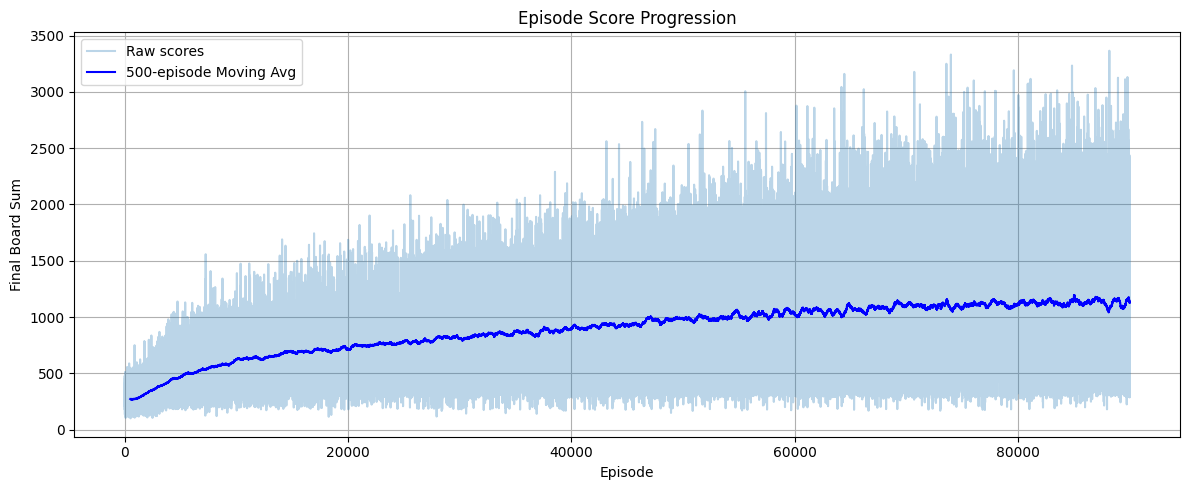

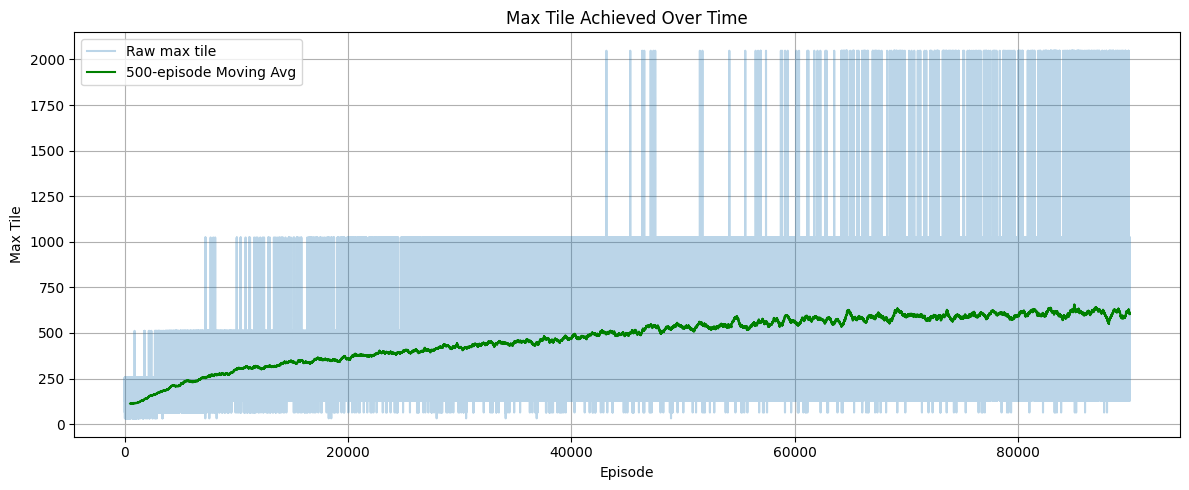


📊 Agent Performance Summary (after 90000 episodes):
→ Average score: 891.57
→ Max score: 3366
→ Average max tile: 470.70
→ Highest tile achieved: 2048


In [147]:
import numpy as np
import matplotlib.pyplot as plt

# Load saved training data
scores = np.load("episode_scores.npy")
max_tiles = np.load("episode_max_tiles.npy")

# Set window size for smoothing
window = 500

# Compute moving averages
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

scores_ma = moving_average(scores, window)
tiles_ma = moving_average(max_tiles, window)

# --- Plot 1: Score Progression ---
plt.figure(figsize=(12, 5))
plt.plot(scores, alpha=0.3, label='Raw scores')
plt.plot(np.arange(window - 1, len(scores)), scores_ma, label=f'{window}-episode Moving Avg', color='blue')
plt.xlabel("Episode")
plt.ylabel("Final Board Sum")
plt.title("Episode Score Progression")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot 2: Max Tile Progression ---
plt.figure(figsize=(12, 5))
plt.plot(max_tiles, alpha=0.3, label='Raw max tile')
plt.plot(np.arange(window - 1, len(max_tiles)), tiles_ma, label=f'{window}-episode Moving Avg', color='green')
plt.xlabel("Episode")
plt.ylabel("Max Tile")
plt.title("Max Tile Achieved Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Summary Stats ---
print(f"\n📊 Agent Performance Summary (after {len(scores)} episodes):")
print(f"→ Average score: {np.mean(scores):.2f}")
print(f"→ Max score: {np.max(scores)}")
print(f"→ Average max tile: {np.mean(max_tiles):.2f}")
print(f"→ Highest tile achieved: {np.max(max_tiles)}")


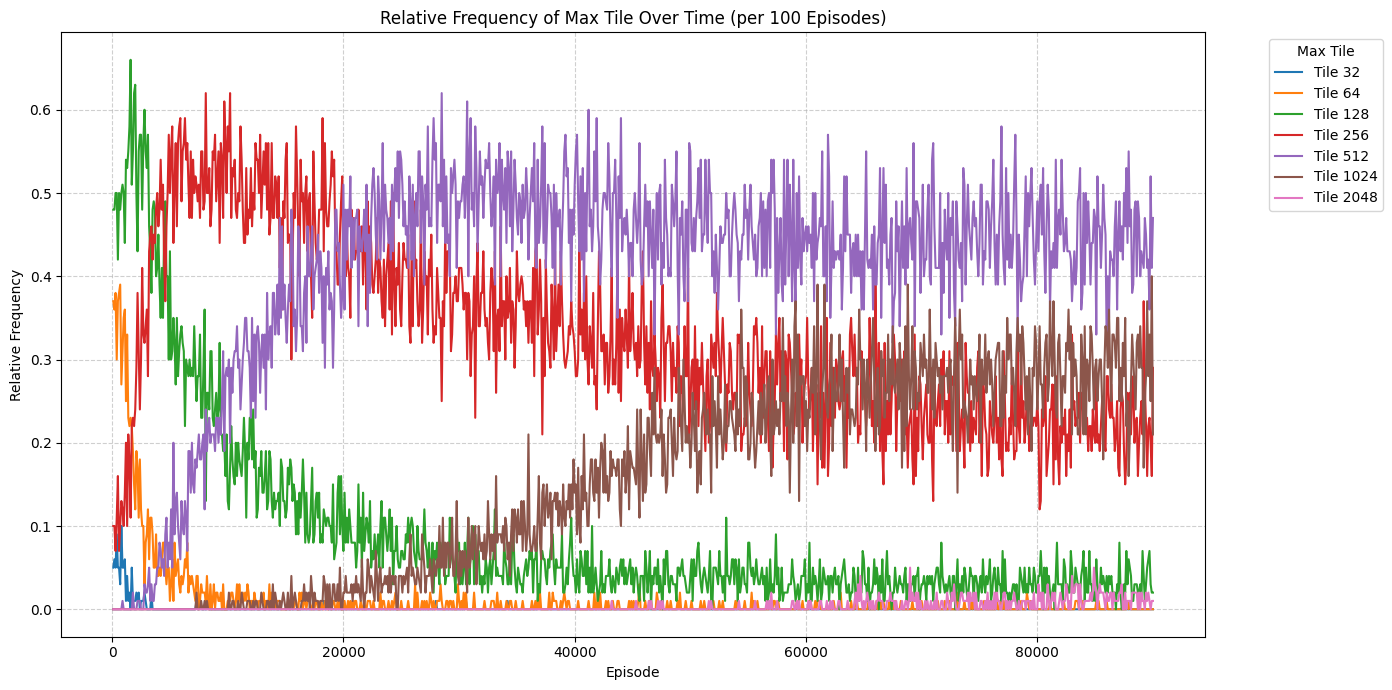

In [148]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load max tile data
max_tiles = np.load("episode_max_tiles.npy")

# Set chunk size
window = 100
n_windows = len(max_tiles) // window

# Collect relative frequency data
records = []

for i in range(n_windows):
    chunk = max_tiles[i * window : (i + 1) * window]
    freqs = dict(pd.Series(chunk).value_counts(normalize=True))
    record = {'Episode': (i + 1) * window}
    for tile, freq in freqs.items():
        record[str(tile)] = freq  # Use string keys to avoid mixed types
    records.append(record)

# Build DataFrame
df = pd.DataFrame(records)
df = df.fillna(0)  # Fill missing tile frequencies with 0

# Plotting
plt.figure(figsize=(14, 7))
tile_columns = [col for col in df.columns if col != 'Episode']
tile_columns_sorted = sorted(tile_columns, key=lambda x: int(x))  # sort numerically

for tile in tile_columns_sorted:
    plt.plot(df['Episode'], df[tile], label=f"Tile {tile}")

plt.xlabel("Episode")
plt.ylabel("Relative Frequency")
plt.title("Relative Frequency of Max Tile Over Time (per 100 Episodes)")
plt.legend(title="Max Tile", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


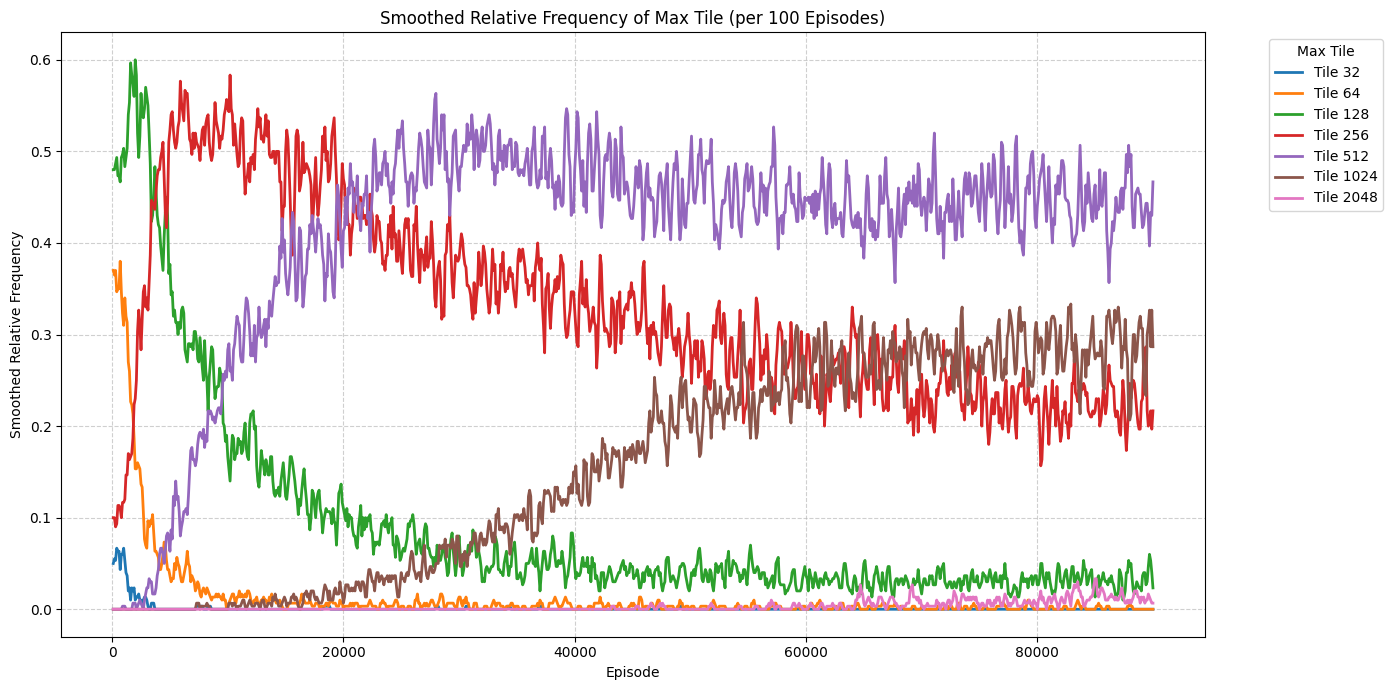

In [149]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load data
max_tiles = np.load("episode_max_tiles.npy")

# Compute frequency every 100 episodes
window = 100
n_windows = len(max_tiles) // window
records = []

for i in range(n_windows):
    chunk = max_tiles[i * window : (i + 1) * window]
    freqs = dict(pd.Series(chunk).value_counts(normalize=True))
    record = {'Episode': (i + 1) * window}
    for tile, freq in freqs.items():
        record[str(tile)] = freq  # Ensure string keys
    records.append(record)

# Build DataFrame
df = pd.DataFrame(records)
df = df.fillna(0)

# Smooth using rolling mean
smooth_df = df.copy()
tile_columns = [col for col in df.columns if col != 'Episode']
tile_columns_sorted = sorted(tile_columns, key=lambda x: int(x))

for tile in tile_columns_sorted:
    smooth_df[tile] = df[tile].rolling(window=3, min_periods=1).mean()

# Plot smoothed frequencies
plt.figure(figsize=(14, 7))
for tile in tile_columns_sorted:
    plt.plot(df['Episode'], smooth_df[tile], label=f"Tile {tile}", linewidth=2)

plt.xlabel("Episode")
plt.ylabel("Smoothed Relative Frequency")
plt.title("Smoothed Relative Frequency of Max Tile (per 100 Episodes)")
plt.legend(title="Max Tile", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


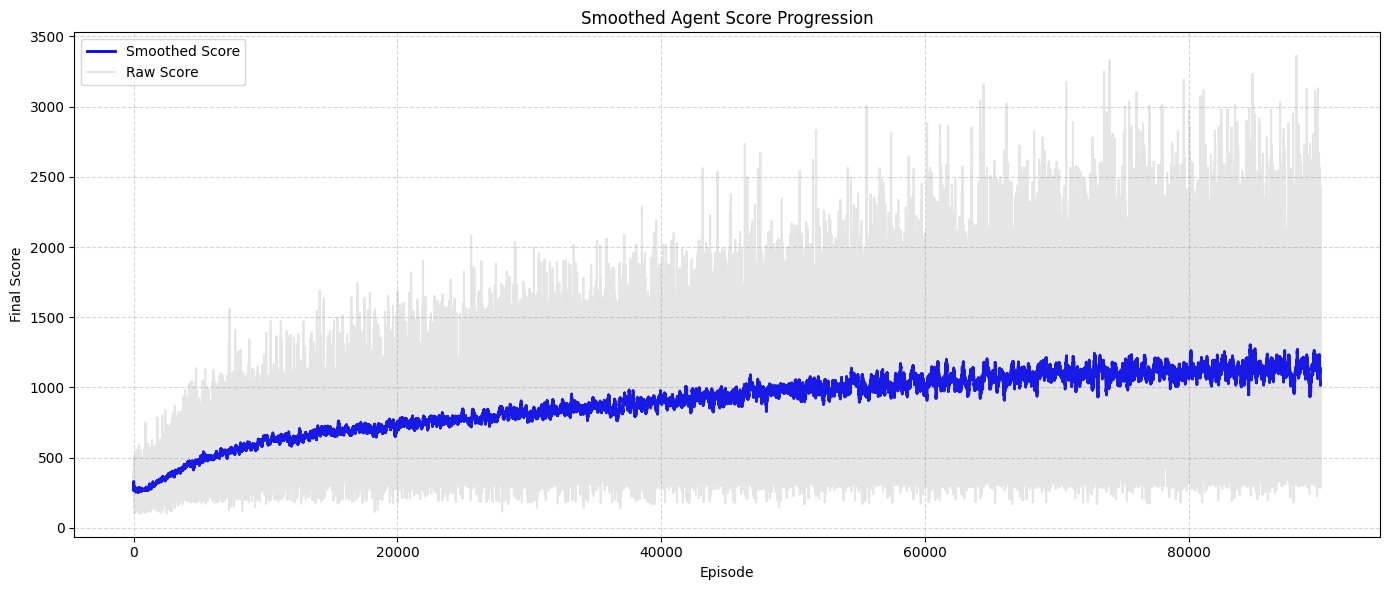

In [150]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load scores
scores = np.load("episode_scores.npy")

# Create a DataFrame for smoothing
df_scores = pd.DataFrame({
    'Episode': np.arange(1, len(scores) + 1),
    'Score': scores
})

# Apply rolling mean (window size 100, you can adjust it)
df_scores['SmoothedScore'] = df_scores['Score'].rolling(window=100, min_periods=1).mean()

# Plot
plt.figure(figsize=(14, 6))
plt.plot(df_scores['Episode'], df_scores['SmoothedScore'], label="Smoothed Score", color='blue', linewidth=2)
plt.plot(df_scores['Episode'], df_scores['Score'], alpha=0.2, label="Raw Score", color='gray')

plt.xlabel("Episode")
plt.ylabel("Final Score")
plt.title("Smoothed Agent Score Progression")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


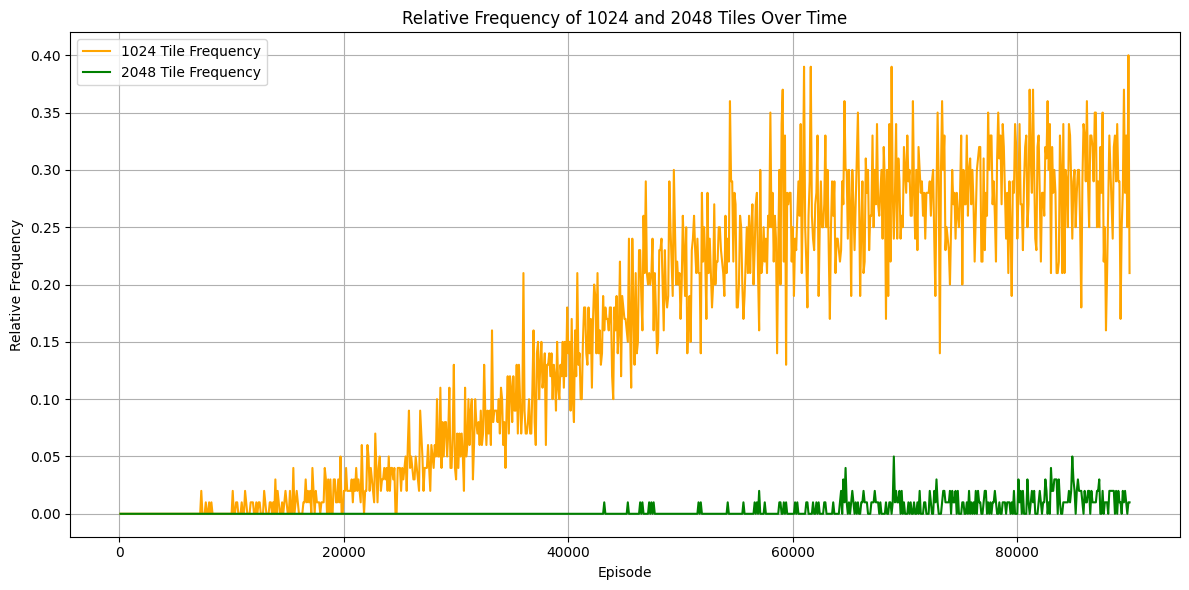

In [151]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load max tile data
max_tiles = np.load('episode_max_tiles.npy')

# Define chunk size
chunk_size = 100
num_chunks = len(max_tiles) // chunk_size

# Initialize frequency counters
freq_1024 = []
freq_2048 = []

# Compute relative frequency per chunk
for i in range(num_chunks):
    chunk = max_tiles[i * chunk_size : (i + 1) * chunk_size]
    freq_1024.append(np.sum(chunk == 1024) / chunk_size)
    freq_2048.append(np.sum(chunk == 2048) / chunk_size)

# Create x-axis (episode number)
x = np.arange(1, num_chunks + 1) * chunk_size

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(x, freq_1024, label='1024 Tile Frequency', color='orange')
plt.plot(x, freq_2048, label='2048 Tile Frequency', color='green')
plt.xlabel('Episode')
plt.ylabel('Relative Frequency')
plt.title('Relative Frequency of 1024 and 2048 Tiles Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [152]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# Simulation
# final_states = [np.random.choice([0, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024], size=(4, 4)) for _ in range(n_episodes)]

# avg_matrix = np.mean(final_states, axis=0)

# # Plot heatmap
# plt.figure(figsize=(6, 5))
# sns.heatmap(avg_matrix, annot=True, fmt=".0f", cmap="YlOrBr")
# plt.title("Average Tile Value per Position (Simulated)")
# plt.xlabel("Column")
# plt.ylabel("Row")
# plt.show()

# TO BE ANALYSED


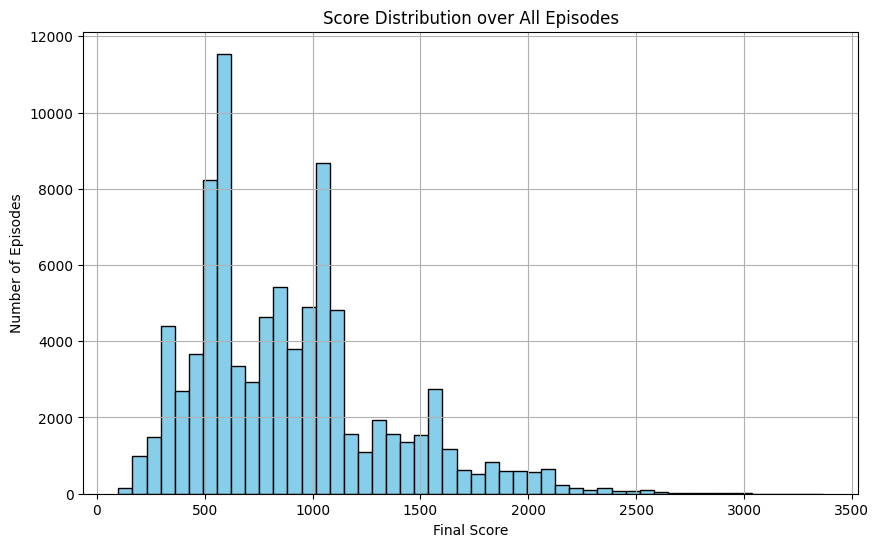

In [153]:
episode_scores = np.load("episode_scores.npy")

plt.figure(figsize=(10, 6))
plt.hist(episode_scores, bins=50, color="skyblue", edgecolor="black")
plt.title("Score Distribution over All Episodes")
plt.xlabel("Final Score")
plt.ylabel("Number of Episodes")
plt.grid(True)
plt.show()


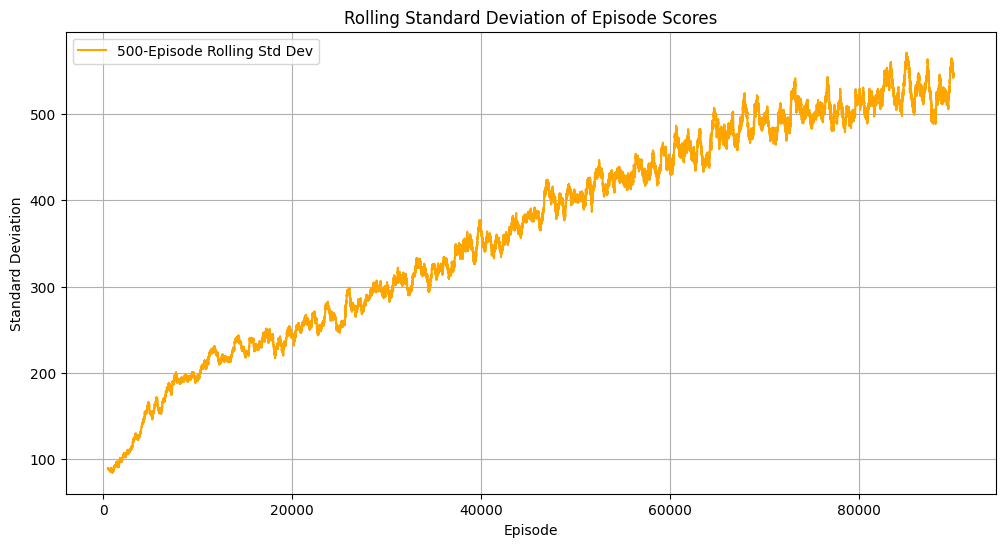

In [154]:
import pandas as pd

rolling_window = 500  # Tune this for smoothness
scores_series = pd.Series(episode_scores)
rolling_std = scores_series.rolling(rolling_window).std()

plt.figure(figsize=(12, 6))
plt.plot(rolling_std, label=f"{rolling_window}-Episode Rolling Std Dev", color="orange")
plt.title("Rolling Standard Deviation of Episode Scores")
plt.xlabel("Episode")
plt.ylabel("Standard Deviation")
plt.grid(True)
plt.legend()
plt.show()


In [155]:
import numpy as np
import builtins  # <-- Import builtins to access the correct `min`

# Load and flatten
episode_scores = np.ravel(np.load("episode_scores.npy"))
episode_max_tiles = np.ravel(np.load("episode_max_tiles.npy"))

# Use built-in min function safely
min_len = builtins.min(len(episode_scores), len(episode_max_tiles))
episode_scores = episode_scores[:min_len]
episode_max_tiles = episode_max_tiles[:min_len]

# Convert to float
episode_scores = episode_scores.astype(float)
episode_max_tiles = episode_max_tiles.astype(float)

# Compute correlation
correlation = np.corrcoef(episode_scores, episode_max_tiles)[0, 1]
print(f"Pearson correlation: {correlation:.4f}")


Pearson correlation: 0.9266


In [156]:
import numpy as np

# Load and prepare data
scores = np.ravel(np.load("episode_scores.npy")).astype(float)
tiles = np.ravel(np.load("episode_max_tiles.npy")).astype(float)

# Case 1: Max tile ≥ 2048
mask_2048 = tiles >= 2048
corr_2048 = np.corrcoef(scores[mask_2048], tiles[mask_2048])[0, 1] if np.sum(mask_2048) > 1 else np.nan

# Case 2: Max tile == 1024
mask_1024 = tiles == 1024
corr_1024 = np.corrcoef(scores[mask_1024], tiles[mask_1024])[0, 1] if np.sum(mask_1024) > 1 else np.nan

# Case 3: Max tile == 512
mask_512 = tiles == 512
corr_512 = np.corrcoef(scores[mask_512], tiles[mask_512])[0, 1] if np.sum(mask_512) > 1 else np.nan

# Output results
print(f"Correlation (score vs tile) for ≥2048: {corr_2048:.4f}")
print(f"Correlation (score vs tile) for =1024: {corr_1024:.4f}")
print(f"Correlation (score vs tile) for =512:  {corr_512:.4f}")

print("Episodes with tile >= 2048:", np.sum(tiles >= 2048))
print("Episodes with tile == 1024:", np.sum(tiles == 1024))
print("Episodes with tile == 512: ", np.sum(tiles == 512))


Correlation (score vs tile) for ≥2048: nan
Correlation (score vs tile) for =1024: nan
Correlation (score vs tile) for =512:  nan
Episodes with tile >= 2048: 289
Episodes with tile == 1024: 13938
Episodes with tile == 512:  36736


C:\Users\maadh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\lib\_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\maadh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\lib\_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


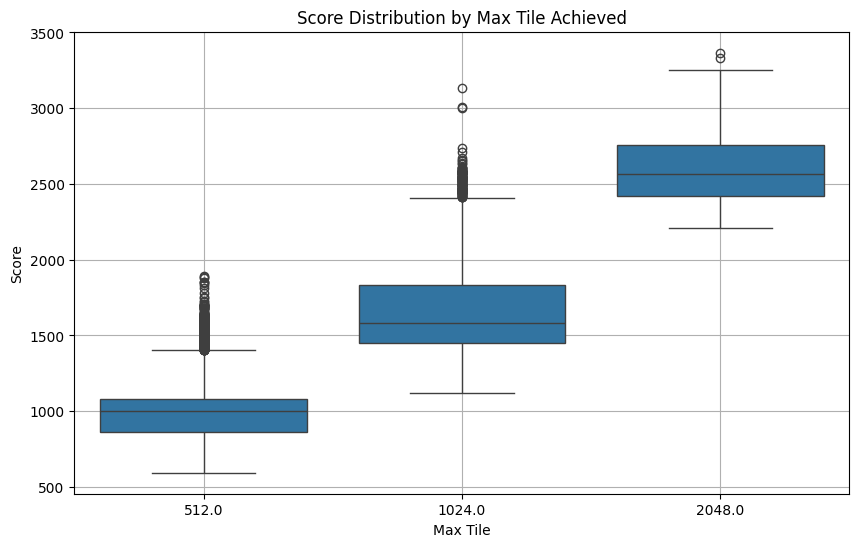

In [157]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Prepare data
df = pd.DataFrame({
    "score": scores,
    "max_tile": tiles
})

# Filter only 512, 1024, 2048
df_filtered = df[df["max_tile"].isin([512, 1024, 2048])]

# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(x="max_tile", y="score", data=df_filtered)
plt.title("Score Distribution by Max Tile Achieved")
plt.xlabel("Max Tile")
plt.ylabel("Score")
plt.grid(True)
plt.show()